In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt

!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

plt.rc('font', family=font_name)

fm._rebuild()

Selecting previously unselected package fonts-nanum-extra.
(Reading database ... 128126 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-extra_20180306-3_all.deb ...
Unpacking fonts-nanum-extra (20180306-3) ...
Selecting previously unselected package fonts-nanum.
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-2_all.deb ...
Unpacking fonts-nanum-coding (2.5-2) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Setting up fonts-nanum-extra (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Setting up fonts-nanum-coding (2.5-2) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...


# 01. EDA 및 전처리

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.decomposition import PCA 

import scipy.cluster.hierarchy as shc

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('/content/drive/MyDrive/머신러닝 프로젝트/Data/Train.csv')
train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [5]:
train.shape

(10999, 12)

## 1. 데이터 탐색

In [6]:
# 데이터 타입
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [7]:
# 데이터 통계값
train.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


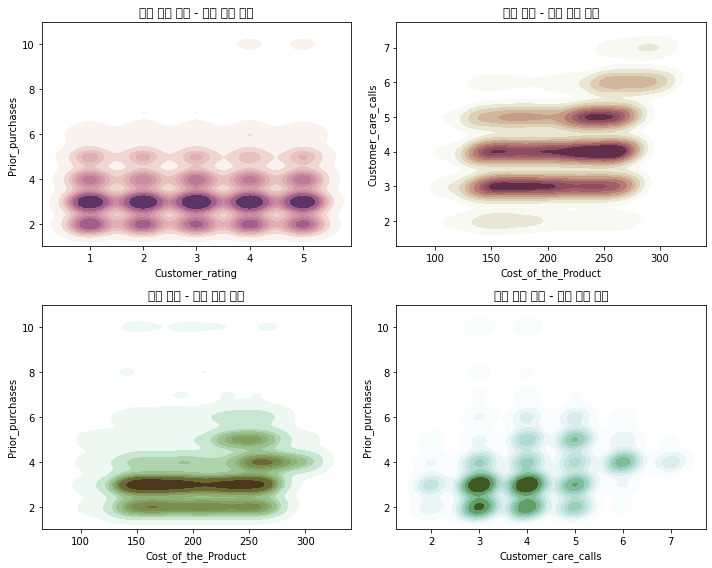

In [8]:
## 변수 간 관계 그래프

# 여러 개의 KDE Plot 생성 준비
f, axes = plt.subplots(2,2,figsize=(10,8),sharex=False,sharey=False)

# plot 색상 설정
s = np.linspace(0,3,10)

# 1-1
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)
x = train['Customer_rating']
y = train['Prior_purchases']
sns.kdeplot(x,y,cmap=cmap, shade=True, ax=axes[0,0])
axes[0,0].set(title='고객 만족 점수 - 이전 구매 횟수')

# 1-2
cmap = sns.cubehelix_palette(start=0.333333333333, light=1, as_cmap=True)
x = train['Cost_of_the_Product']
y = train['Customer_care_calls']
sns.kdeplot(x, y, cmap=cmap, shade=True, ax=axes[0,1])
axes[0,1].set( title = '상품 비용 - 고객 응답 횟수')

# 2-1
cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
x = train['Cost_of_the_Product']
y = train['Prior_purchases']
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,0])
axes[1,0].set( title = '상품 비용 - 이전 구매 횟수')

#2-2
cmap = sns.cubehelix_palette(start=1.333333333333, light=1, as_cmap=True)
x = train['Customer_care_calls']
y = train['Prior_purchases']
sns.kdeplot(x, y, cmap=cmap, shade=True,  ax=axes[1,1])
axes[1,1].set( title = '고객 응답 횟수 - 이전 구매 횟수')

f.tight_layout()

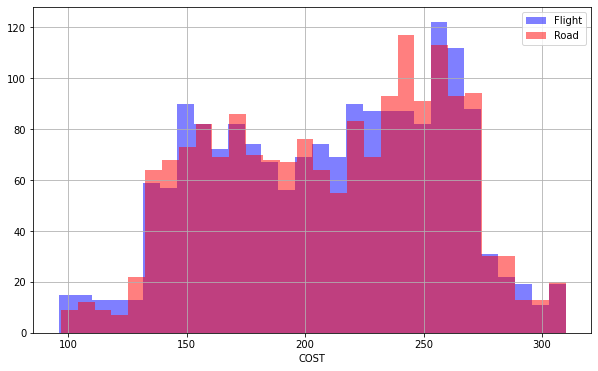

In [9]:
plt.figure(figsize=(10,6))
train[train['Mode_of_Shipment']=='Flight']['Cost_of_the_Product'].hist(alpha=0.5,color='blue',bins=30,label='Flight')
train[train['Mode_of_Shipment']=='Road']['Cost_of_the_Product'].hist(alpha=0.5,color='red',bins=30,label='Road')
plt.xlabel('COST')
plt.legend()

In [10]:
# 결측값
train.isnull().any()

ID                     False
Warehouse_block        False
Mode_of_Shipment       False
Customer_care_calls    False
Customer_rating        False
Cost_of_the_Product    False
Prior_purchases        False
Product_importance     False
Gender                 False
Discount_offered       False
Weight_in_gms          False
Reached.on.Time_Y.N    False
dtype: bool

In [11]:
# 중복값
print("중복된 항목 수 :", len(train[train.duplicated()]))

중복된 항목 수 : 0


## 2. 데이터 전처리

In [12]:
# 데이터 컬럼명 수정
train = train.rename(columns={"Reached.on.Time_Y.N":"Reached_on_Time_Y_N"})

## 3. Target Feature 정의

### 1) 데이터 탐색

In [13]:
train.groupby('Reached_on_Time_Y_N').mean()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
Reached_on_Time_Y_N,,,,,,,
0,7090.479486,4.147656,2.967989,214.498647,3.670424,5.545987,4168.668395
1,4424.978364,3.991467,3.005790,207.289197,3.498095,18.663721,3272.640104


In [14]:
train.groupby('Reached_on_Time_Y_N').median()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
Reached_on_Time_Y_N,,,,,,,
0,7096.0,4.0,3.0,222.0,3.0,6.0,4674.0
1,3467.0,4.0,3.0,209.0,3.0,9.0,3231.0


In [15]:
y = train['Reached_on_Time_Y_N'].copy()
y.value_counts()

1    6563
0    4436
Name: Reached_on_Time_Y_N, dtype: int64

### 2) 숫자형 변수들과의 관계

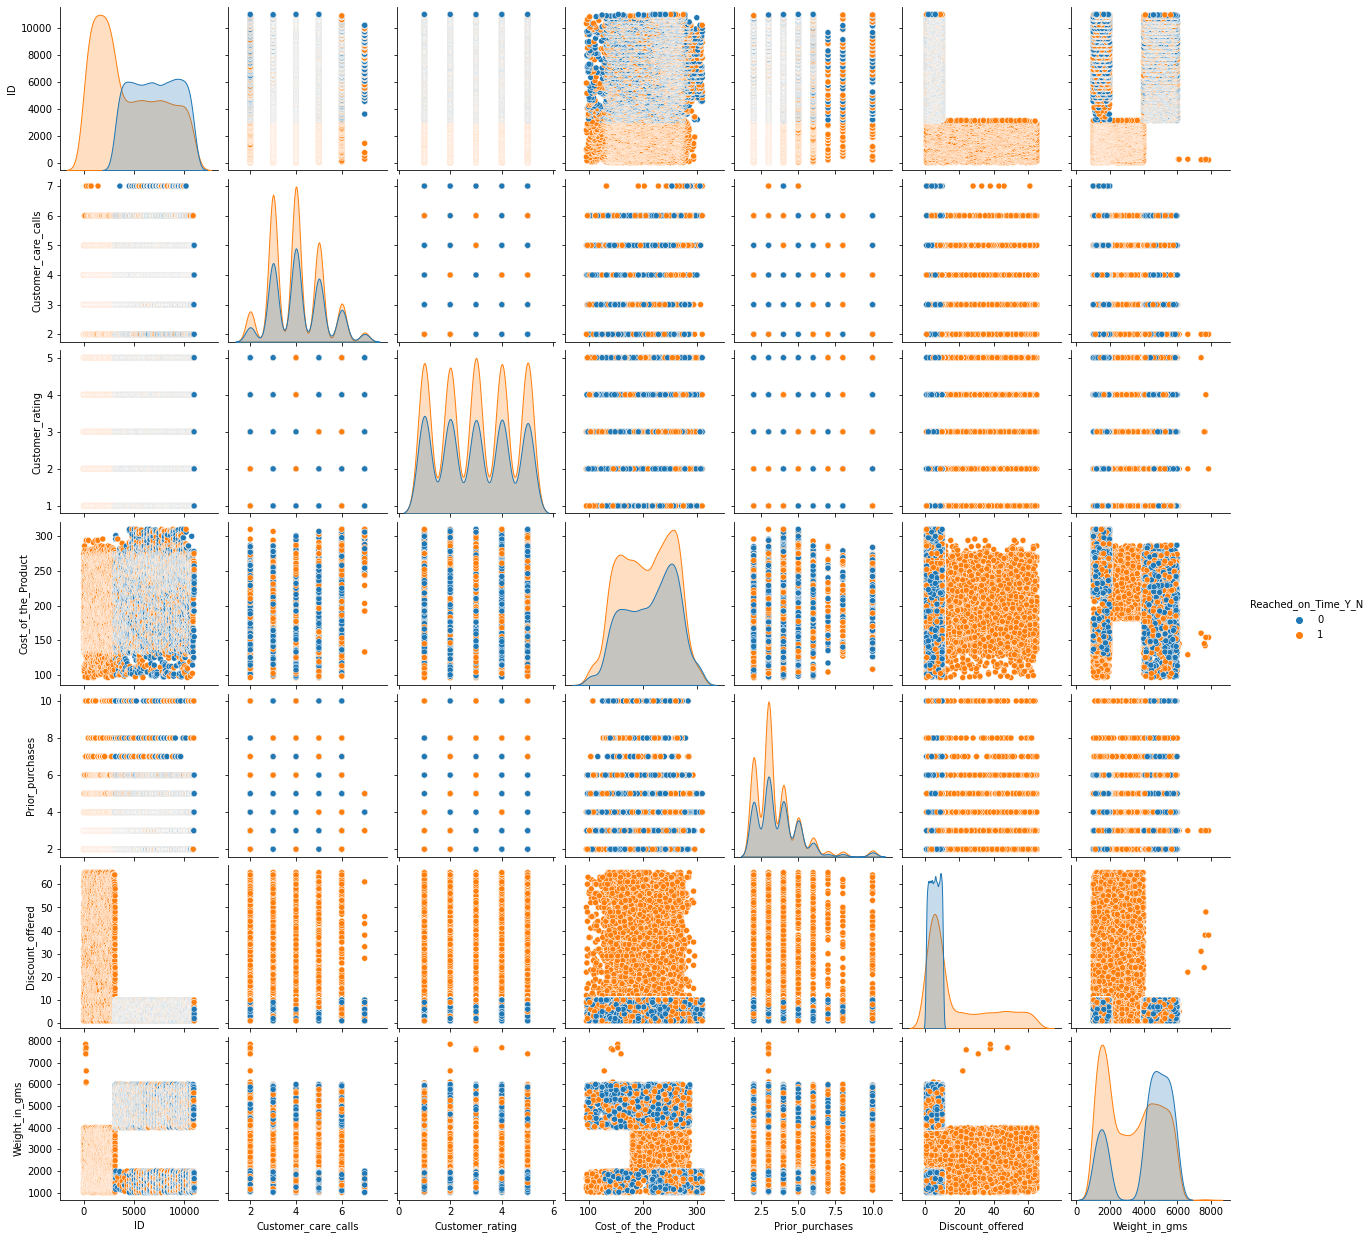

In [16]:
hue = 'Reached_on_Time_Y_N'
sns.pairplot(train.select_dtypes(include=np.number),hue=hue)
plt.show()

### 3) 각 변수별 Target Feature 그래프

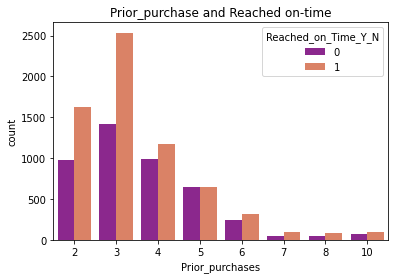

In [17]:
# 이전 구매횟수 별 target feature
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x='Prior_purchases', data=train, palette='plasma', hue='Reached_on_Time_Y_N');
plt.title('Prior_purchase and Reached on-time')
plt.show()

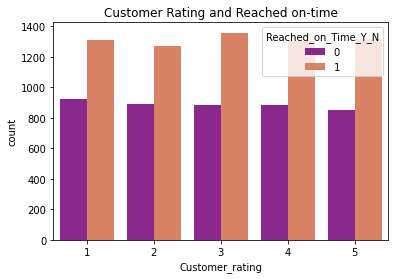

In [18]:
# 고객 평가 점수별 target feature
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x='Customer_rating', data=train, palette='plasma', hue='Reached_on_Time_Y_N');
plt.title('Customer Rating and Reached on-time')
plt.show()

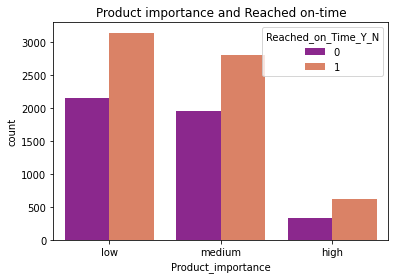

In [19]:
# 상품 중요도별 target feature
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x='Product_importance', data=train, palette='plasma', hue='Reached_on_Time_Y_N');
plt.title('Product importance and Reached on-time')
plt.show()

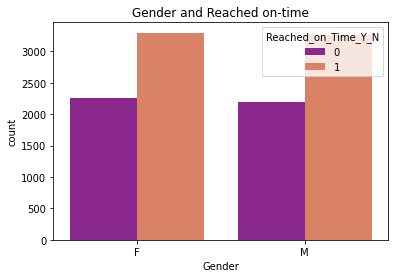

In [20]:
# 성별에 따른 target feature
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x='Gender', data=train, palette='plasma', hue='Reached_on_Time_Y_N');
plt.title('Gender and Reached on-time')
plt.show()

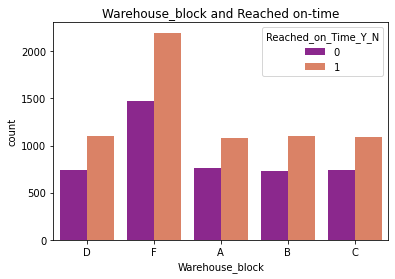

In [21]:
# 창고 구역별 target feature
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x='Warehouse_block', data=train, palette='plasma', hue='Reached_on_Time_Y_N');
plt.title('Warehouse_block and Reached on-time')
plt.show()

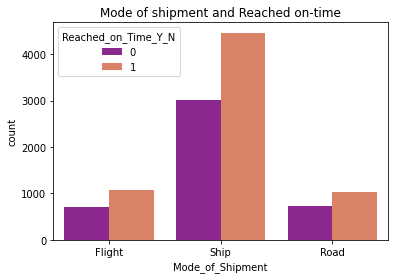

In [22]:
# 운송 수단별 target feature
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x='Mode_of_Shipment', data=train, palette='plasma', hue='Reached_on_Time_Y_N');
plt.title('Mode of shipment and Reached on-time')
plt.show()

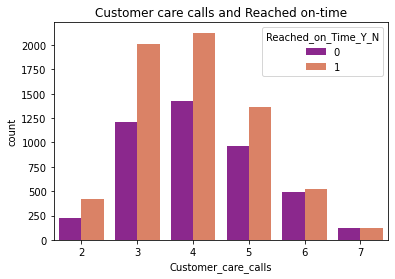

In [23]:
# 고객 응답 횟수별 target feature
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x='Customer_care_calls', data=train, palette='plasma', hue='Reached_on_Time_Y_N');
plt.title('Customer care calls and Reached on-time')
plt.show()

## 4. 데이터 타입별 Feature 변환

### 1) Feature 탐색

In [24]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached_on_Time_Y_N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None


In [25]:
# 데이터 타입별 컬럼 수 확인
dtype_data = train.dtypes.reset_index()
dtype_data.columns = ['Count','Column Type']
dtype_data = dtype_data.groupby('Column Type').aggregate('count').reset_index()

print(dtype_data)

  Column Type  Count
0       int64      8
1      object      4


### 2) 범주형 Feature
* 데이터 확인
* Feature 별 개수 시각화
* 날짜/숫자/기간 등으로 변환해야 할 항목이 있는지 확인
* Feature 별 개수 시각화
* Feature의 개수가 인코딩에 적합한가?

##### 데이터 확인

In [27]:
train.select_dtypes(include=['object','category']).head()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
0,D,Flight,low,F
1,F,Flight,low,M
2,A,Flight,low,M
3,B,Flight,medium,M
4,C,Flight,medium,F


##### Feature 제거

In [28]:
# feature별 유일한 값 개수 확인
cat_feat = train.select_dtypes('object','category').columns.values
train_cat = train[cat_feat].copy()
print(train_cat.nunique().sort_values())

Gender                2
Mode_of_Shipment      3
Product_importance    3
Warehouse_block       5
dtype: int64


> 유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거
* Target Feature가 포함되어 있으면 함께 제거

##### Feature 별 개수 시각화

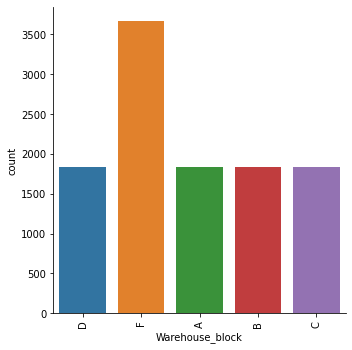

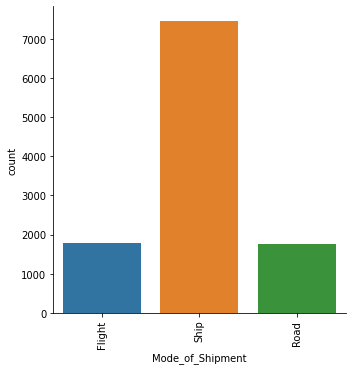

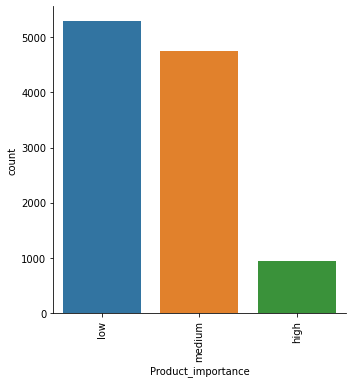

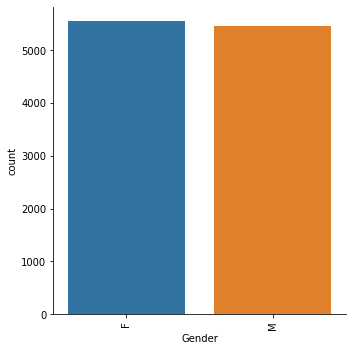

In [29]:
for col in train_cat.columns:
  fig = sns.catplot(x=col,kind='count',data=train_cat,hue=None)
  fig.set_xticklabels(rotation=90)
  plt.show()

##### Feature의 개수가 인코딩에 적합한가?
* 인코딩을 했을 경우 메모리 문제가 발생하지 않는가?

> Feature 인코딩
* LabelEncoder : LabelEncoder 는 선형성을 가지는 머신러닝 기법에 쓰면 좋지 않다
* OneHotEncoder vs. get_dummies

In [30]:
train_cat_dummies = pd.get_dummies(train_cat)
train_cat_dummies.head(3)

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,0,0,0,1,0,1,0,0,0,1,0,1,0
1,0,0,0,0,1,1,0,0,0,1,0,0,1
2,1,0,0,0,0,1,0,0,0,1,0,0,1


### 3) 숫자형 Feature
* 데이터 확인 
* Feature 제거
* Feature Skewness 확인

##### 데이터 확인

In [31]:
train.select_dtypes(include=['number']).head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached_on_Time_Y_N
0,1,4,2,177,3,44,1233,1
1,2,4,5,216,2,59,3088,1
2,3,2,2,183,4,48,3374,1
3,4,3,3,176,4,10,1177,1
4,5,2,2,184,3,46,2484,1


In [32]:
num_feat = train.select_dtypes('number').columns.values
train_num = train[num_feat].copy()

##### Feature 제거

In [33]:
# feature 별 유일한 값 개수 확인
print(train_num.nunique().sort_values())

Reached_on_Time_Y_N        2
Customer_rating            5
Customer_care_calls        6
Prior_purchases            8
Discount_offered          65
Cost_of_the_Product      215
Weight_in_gms           4034
ID                     10999
dtype: int64


In [34]:
print(train.shape)

(10999, 12)


> 유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거한다
* Target Feature 가 포함되어 있으면 함께 제거

In [35]:
train_num = train_num.drop(['ID','Reached_on_Time_Y_N'],axis=1,errors='ignore')

##### Feature Skewness 확인

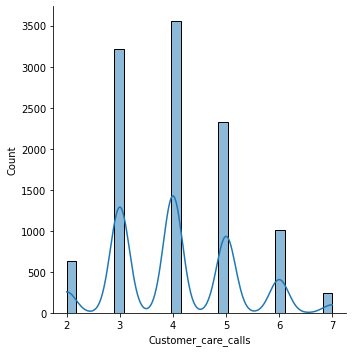

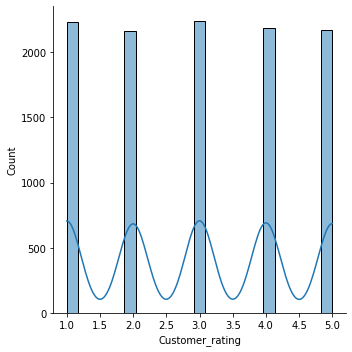

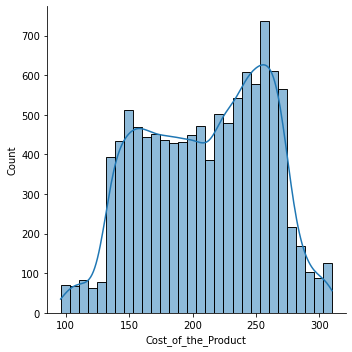

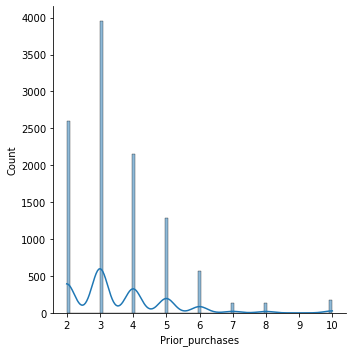

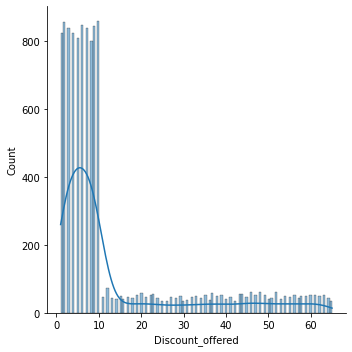

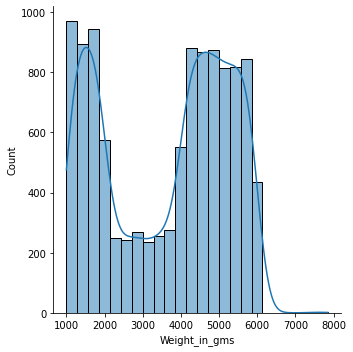

In [36]:
col_attrition_num = train_num.columns.values
for i in range(0,len(col_attrition_num)):
  sns.displot(train_num[col_attrition_num[i]],kde=True)

## 5. 상관성에 따른 Feature 정제

### 1) 숫자형 Feature
* 데이터 확인
* 숫자형 컬럼들 간 Person R 상관계수
* 상관 계수가 0.9 이상인 컬럼들 중 가장 큰 컬럼 제거
* 컬럼들 간 조합 생성 : comb_num_feat=np.array(list(combinations(num_feat,2)))
* Person R 상관 계수 구하기 : personr(x1,x2)[0]

##### 데이터 확인

In [39]:
train_num.nunique().sort_values()

Customer_rating           5
Customer_care_calls       6
Prior_purchases           8
Discount_offered         65
Cost_of_the_Product     215
Weight_in_gms          4034
dtype: int64

##### 상관계수 구하기

* 방법 1

In [40]:
num_feat = train_num.columns.values
comb_num_feat = np.array(list(combinations(num_feat,2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
  corr = pearsonr(train_num[comb[0]], train_num[comb[1]])[0]
  corr_num_feat = np.append(corr_num_feat, corr)

In [42]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat)>=0.9]
high_corr_num

array([], shape=(0, 2), dtype='<U19')

* 방법 2

In [43]:
# plotly 안 보이는 문제 해결
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.renderers
pio.renderers.default = 'colab'
pio.renderers

data = [
    go.Heatmap(
        z=train_num.astype(float).corr().values, #피어슨 상관계수
        x=train_num.columns.values,
        y=train_num.columns.values,
        colorscale='Viridis',
        reversescale=False,
        opacity=1.0
    )
]

layout = go.Layout(
    title='숫자형 Feature 들의 피어슨 상관계수',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

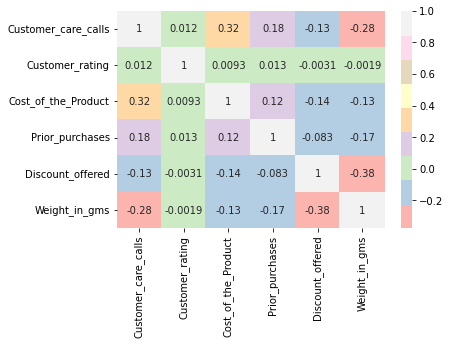

In [46]:
sns.heatmap(train_num.corr(),annot=True,cmap='Pastel1')

### 2) 범주형 Feature
* 데이터 확인

In [47]:
train_cat_dummies.nunique().sort_values()

Warehouse_block_A            2
Warehouse_block_B            2
Warehouse_block_C            2
Warehouse_block_D            2
Warehouse_block_F            2
Mode_of_Shipment_Flight      2
Mode_of_Shipment_Road        2
Mode_of_Shipment_Ship        2
Product_importance_high      2
Product_importance_low       2
Product_importance_medium    2
Gender_F                     2
Gender_M                     2
dtype: int64

In [48]:
train_cat_dummies.head()

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,0,0,0,1,0,1,0,0,0,1,0,1,0
1,0,0,0,0,1,1,0,0,0,1,0,0,1
2,1,0,0,0,0,1,0,0,0,1,0,0,1
3,0,1,0,0,0,1,0,0,0,0,1,0,1
4,0,0,1,0,0,1,0,0,0,0,1,1,0


In [49]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1,var2):
  crosstab = np.array(pd.crosstab(var1,var2,rownames=None,colnames=None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape)-1
  return (stat/(obs*mini))

In [50]:
rows = []

for var1 in train_cat_dummies:
  col = []
  for var2 in train_cat_dummies:
    cramers = cramers_V(train_cat_dummies[var1],train_cat_dummies[var2])
    col.append(round(cramers,2))
  rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns=train_cat_dummies.columns, index=train_cat_dummies.columns)

df

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
Warehouse_block_A,1.00,0.04,0.04,0.04,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_B,0.04,1.00,0.04,0.04,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_C,0.04,0.04,1.00,0.04,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_D,0.04,0.04,0.04,1.00,0.1,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_F,0.10,0.10,0.10,0.10,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Flight,0.00,0.00,0.00,0.00,0.0,1.00,0.04,0.41,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Road,0.00,0.00,0.00,0.00,0.0,0.04,1.00,0.40,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Ship,0.00,0.00,0.00,0.00,0.0,0.41,0.40,1.00,0.00,0.00,0.00,0.0,0.0
Product_importance_high,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1.00,0.09,0.07,0.0,0.0
Product_importance_low,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.09,1.00,0.71,0.0,0.0


In [51]:
np.sum(df>0.9)

Warehouse_block_A            1
Warehouse_block_B            1
Warehouse_block_C            1
Warehouse_block_D            1
Warehouse_block_F            1
Mode_of_Shipment_Flight      1
Mode_of_Shipment_Road        1
Mode_of_Shipment_Ship        1
Product_importance_high      1
Product_importance_low       1
Product_importance_medium    1
Gender_F                     2
Gender_M                     2
dtype: int64

In [52]:
train_final = pd.concat([train['Reached_on_Time_Y_N'],train_num,train_cat_dummies],axis=1)

In [53]:
train_final.head()

,Reached_on_Time_Y_N,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,1,4,2,177,3,44,1233,0,0,0,1,0,1,0,0,0,1,0,1,0
1,1,4,5,216,2,59,3088,0,0,0,0,1,1,0,0,0,1,0,0,1
2,1,2,2,183,4,48,3374,1,0,0,0,0,1,0,0,0,1,0,0,1
3,1,3,3,176,4,10,1177,0,1,0,0,0,1,0,0,0,0,1,0,1
4,1,2,2,184,3,46,2484,0,0,1,0,0,1,0,0,0,0,1,1,0


In [54]:
target = train["Reached_on_Time_Y_N"]

In [55]:
X = pd.concat([train_num, train_cat_dummies],axis=1)
Y = train["Reached_on_Time_Y_N"]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30)

# 03. 예측 분석
고객 정보를 활용한 정시 배송 예측

### 1) Logistic Regression

##### 모델 생성

In [58]:
model=LogisticRegression()
model.fit(X_train, y_train)
lr_predictions=model.predict(X_test)

##### 모델 평가

In [59]:
print("Accuracy score: {}".format(accuracy_score(y_test, lr_predictions)))
print("="*60)
print(classification_report(y_test, lr_predictions))

Accuracy score: 0.6321212121212121
              precision    recall  f1-score   support

           0       0.55      0.56      0.56      1348
           1       0.69      0.68      0.69      1952

    accuracy                           0.63      3300
   macro avg       0.62      0.62      0.62      3300
weighted avg       0.63      0.63      0.63      3300



##### RFE(Recursive Feature Elimination) 적용

RFE는 변수선택방법으로, 원하는 개수의 변수들이 남을때 까지 학습을 반복하며 유의미하지 않은 변수들을 제거해나가는 Backward 방식이다. 분석가가 변수 선택을 위해 사용하려는 알고리즘을 선택하면, 먼저 모든 입력 변수를 사용해 모델을 학습하고 변수들의 변수 중요도를 계산한다. 그리고 변수 중요도가 낮은 변수들을 이후 단계에서 제거하는 방식이다. 그렇게 지정한 개수만큼 변수가 남을 때까지 반복한다.

In [64]:
# Backward
from sklearn.feature_selection import RFE

rfe = RFE(model, n_features_to_select=6)
X_rfe = rfe.fit_transform(X,Y)
model.fit(X_rfe,Y)

print('Number of Features : {}'.format(rfe.n_features_))
print('Is feature selected? : {}'.format(rfe.support_))
print('Ranking of Features : {}'.format(rfe.ranking_))
print(X.columns[rfe.support_])

Number of Features : 6
Is feature selected? : [False False False  True  True False  True False False False False False
 False False False  True  True False  True]
Ranking of Features : [12  9 13  1  1 14  1  2  8  4  7 10  6 11  3  1  1  5  1]
Index(['Prior_purchases', 'Discount_offered', 'Warehouse_block_A',
       'Product_importance_low', 'Product_importance_medium', 'Gender_M'],
      dtype='object')


##### SelectKBest 적용
target변수와 그 외 변수 사이의 상관관계를 계산하여 가장 상관관계가 높은 변수 k개 선정

최적의 특성 수를 구하고 해당 특성들을 이용하도록

성능이 좋은 변수만 사용

In [65]:
# Univariate Selection 종속1,독립 여러개
# 카이제곱통계량 기준으로 best뽑기
X_new = SelectKBest(chi2, k=6).fit_transform(X,Y)

In [66]:
X_new_train,X_new_test,y_new_train,y_new_test = train_test_split(X_new,Y,test_size=0.30)

In [67]:
model = LogisticRegression()
model.fit(X_new_train,y_new_train)
lr_predictions = model.predict(X_new_test)

In [68]:
print("Accuracy score: {}".format(accuracy_score(y_new_test, lr_predictions)))
print("="*60)
print(classification_report(y_new_test,lr_predictions))

Accuracy score: 0.6324242424242424
              precision    recall  f1-score   support

           0       0.55      0.54      0.55      1353
           1       0.69      0.69      0.69      1947

    accuracy                           0.63      3300
   macro avg       0.62      0.62      0.62      3300
weighted avg       0.63      0.63      0.63      3300



### 2) SVM

##### Feature Scaling

In [69]:
sc_x = StandardScaler() #표준화
X_train_sc = sc_x.fit_transform(X_train)
X_test_sc = sc_x.transform(X_test)

##### 모델 생성

In [70]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train_sc, y_train)
clf_predictions = clf.predict(X_test_sc)

##### 모델 평가

In [71]:
print("Accuracy score: {}".format(accuracy_score(y_test,clf_predictions.round(), normalize=True)))
print("="*60)
print(classification_report(y_test,clf_predictions))

Accuracy score: 0.6727272727272727
              precision    recall  f1-score   support

           0       0.58      0.75      0.65      1348
           1       0.78      0.62      0.69      1952

    accuracy                           0.67      3300
   macro avg       0.68      0.68      0.67      3300
weighted avg       0.70      0.67      0.68      3300



##### SelectKBest 적용 후 평가

In [72]:
X_norm = MinMaxScaler().fit_transform(X)
X_new = SelectKBest(chi2,k=6).fit_transform(X_norm, Y)

X_new_train,X_new_test,y_new_train,y_new_test = train_test_split(X_new,Y, test_size=0.30)
clf = svm.SVC(kernel='linear')
clf.fit(X_new_train,y_new_train)
clf_predictions = clf.predict(X_new_test)

print("Accuracy score: {}".format(accuracy_score(y_new_test, clf_predictions.round(), normalize=True)))
print("="*60)
print(classification_report(y_new_test, clf_predictions))

Accuracy score: 0.656969696969697
              precision    recall  f1-score   support

           0       0.56      0.73      0.63      1344
           1       0.77      0.61      0.68      1956

    accuracy                           0.66      3300
   macro avg       0.66      0.67      0.66      3300
weighted avg       0.68      0.66      0.66      3300



### 3) RandomForest

##### 모델 생성

In [73]:
rf = RandomForestRegressor(n_estimators=20, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [74]:
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred.round())))

Accuracy score: 0.6663636363636364


##### Feature Importance

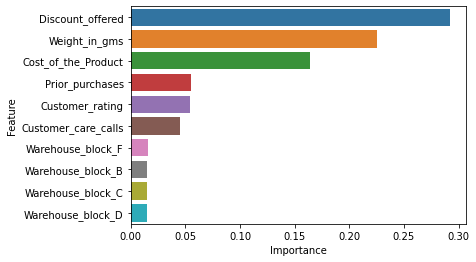

In [75]:
feat = X.columns.values
imp = rf.feature_importances_
df = pd.DataFrame({'Feature':feat, 'Importance':imp})
df = df.sort_values('Importance',ascending=False)[:10]
sns.barplot(x='Importance',y='Feature',data=df);

In [76]:
trace = go.Scatter(
    y = rf.feature_importances_,
    x = X.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = X.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

##### RFE(Recursive Feature Elimination) 적용

In [79]:
rfe = RFE(rf, n_features_to_select=6)
X_rfe = rfe.fit_transform(X,Y)
rf.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True False False False False False False
 False False False False False False False]
[ 1  1  1  1  1  1  8  7  6 10  4 11 12  5 14  3  9  2 13]


##### SelectKBest 적용 후 평가

In [80]:
X_new = SelectKBest(chi2, k=6).fit_transform(X,Y)
X_new_train,X_new_test,y_new_train,y_new_test = train_test_split(X_new,Y,test_size=0.30)
rf = RandomForestRegressor(n_estimators=20,random_state=0)
rf.fit(X_new_train, y_new_train)
y_pred = rf.predict(X_new_test)

print("Accuracy score: {}".format(accuracy_score(y_new_test, y_pred.round())))

Accuracy score: 0.6475757575757576


### 4) XGBoost

##### 모델 생성

In [81]:
xgmodel = XGBClassifier()
xgmodel.fit(X_train,y_train)
y_pred = xgmodel.predict(X_test)

In [82]:
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred.round())))

Accuracy score: 0.6921212121212121


##### RFE 적용

In [84]:
rfe = RFE(xgmodel, n_features_to_select=6)
X_rfe = rfe.fit_transform(X,Y)
xgmodel.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True  True  True False  True False False False  True
 False False False False False False False]
[ 5  8  1  1  1  1 11  1 13  2 12  1  7  4  6  3 10  9 14]


##### SelectKBest 적용 후 평가

In [85]:
X_new = SelectKBest(chi2, k=6).fit_transform(X, Y)

X_new_train,X_new_test,y_new_train,y_new_test=train_test_split(X_new,Y,test_size=0.30)
xgmodel=XGBClassifier()
xgmodel.fit(X_new_train,y_new_train)
y_pred = xgmodel.predict(X_new_test)

print("Accuracy score: {}".format(accuracy_score(y_new_test, y_pred.round())))

Accuracy score: 0.6790909090909091


# 04. 군집 분석
군집 분석을 활용한 고객 Segmentation

### 1) K-Means Clustering

##### Elbow 방법 적용

In [86]:
clustdata = train_final[(train_final.Reached_on_Time_Y_N==1)]

In [90]:
wcss=[]

for i in range(1,15):
  kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0)
  kmeans.fit(clustdata)
  wcss.append(kmeans.inertia_) #적정 군집수 판단

WCSS는 클러스터의 각 구성원과 중심 사이의 거리 제곱의 합

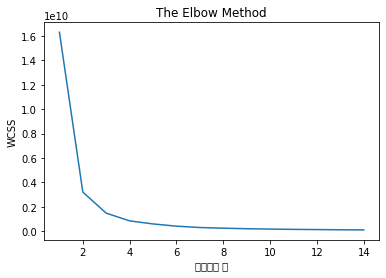

In [91]:
plt.plot(range(1,15), wcss)
plt.title('The Elbow Method')
plt.xlabel('클러스터 수')
plt.ylabel('WCSS')
plt.show()

In [92]:
km = KMeans(n_clusters=2, init='k-means++', n_init=10)
c = km.fit_predict(clustdata)
c

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [93]:
clustdata['Cluster']=c
clustdata.head()

,Reached_on_Time_Y_N,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,...,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M,Cluster
0,1,4,2,177,3,44,1233,0,0,0,...,0,1,0,0,0,1,0,1,0,1
1,1,4,5,216,2,59,3088,0,0,0,...,1,1,0,0,0,1,0,0,1,1
2,1,2,2,183,4,48,3374,1,0,0,...,0,1,0,0,0,1,0,0,1,0
3,1,3,3,176,4,10,1177,0,1,0,...,0,1,0,0,0,0,1,0,1,1
4,1,2,2,184,3,46,2484,0,0,1,...,0,1,0,0,0,0,1,1,0,1


In [94]:
clustdata.groupby(['Cluster']).mean()

,Reached_on_Time_Y_N,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
Cluster,,,,,,,,,,,,,,,,,,,,
0,1.0,3.821617,3.020749,208.292970,3.354289,11.154227,4709.394240,0.162589,0.167234,0.166925,0.169712,0.333540,0.169712,0.156705,0.673583,0.109631,0.443791,0.446578,0.492722,0.507278
1,1.0,4.155969,2.991302,206.317037,3.637373,25.936713,1881.134673,0.164967,0.169166,0.166467,0.164367,0.335033,0.156269,0.158668,0.685063,0.078584,0.511998,0.409418,0.511398,0.488602


##### 군집화된 데이터 Scaling

In [95]:
scaler = StandardScaler() #표준화
X_scaled = scaler.fit_transform(clustdata)

X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)

##### PCA 적용 (n=2)

In [96]:
pca = PCA(n_components=2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns=['P1','P2']

In [97]:
c1 = km.fit_predict(X_principal)
c1

array([1, 0, 0, ..., 1, 0, 1], dtype=int32)

In [98]:
result = pd.DataFrame({'P1':X_principal.iloc[:,0],'P2':X_principal.iloc[:,1]})
result['Cluster']=pd.Series(c1, index=result.index)
result.head()

,P1,P2,Cluster
0,-0.511747,-0.227254,1
1,-0.314457,0.373794,0
2,-0.002495,0.293510,0
3,-0.107519,0.220586,0
4,-0.194810,-0.368113,1


##### 주성분-클러스터 그래프

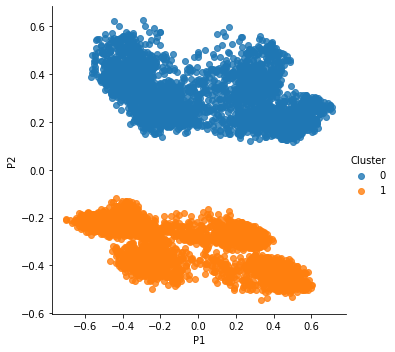

In [99]:
import seaborn as sns
facet = sns.lmplot(data=result,x='P1',y='P2',hue='Cluster',fit_reg=False,legend=True,legend_out=True)

In [100]:
result['Cluster'].value_counts()

1    3296
0    3267
Name: Cluster, dtype: int64

##### PCA 후 Elbow 방법 적용

In [101]:
wcss=[]

for i in range(2,15):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X_principal)
    wcss.append(kmeans.inertia_)

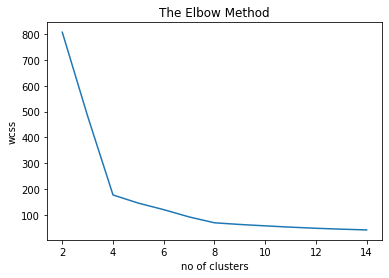

In [102]:
plt.plot(range(2,15), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

In [103]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, init='k-means++', n_init=10)
c = km.fit_predict(X_principal) 
c

array([3, 1, 1, ..., 3, 1, 3], dtype=int32)

In [104]:
result=pd.DataFrame({'P1' : X_principal.iloc[:,0] ,'P2' : X_principal.iloc[:,1]})
result['Cluster']=pd.Series(c, index=result.index)
result.head()

,P1,P2,Cluster
0,-0.511747,-0.227254,3
1,-0.314457,0.373794,1
2,-0.002495,0.293510,1
3,-0.107519,0.220586,1
4,-0.194810,-0.368113,3


##### 새로운 주성분-클러스터 그래프

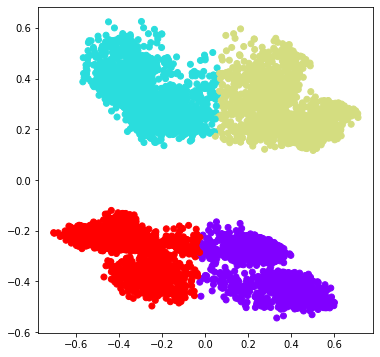

In [107]:
plt.figure(figsize =(6, 6)) 
plt.scatter(result.iloc[:,0],result.iloc[:,1],c=result['Cluster'], cmap ='rainbow') 
plt.show()

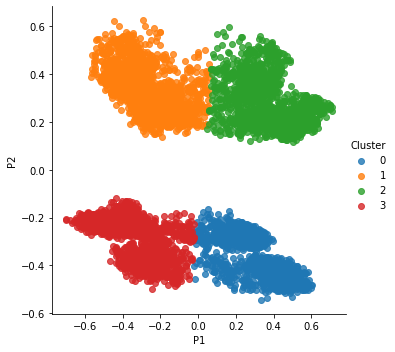

In [108]:
import seaborn as sns
facet = sns.lmplot(data=result,x='P1',y='P2',hue='Cluster', fit_reg=False, legend=True, legend_out=True)